In [45]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as wg
from IPython.display import display

In [46]:
##### General Constants #######

# Actuator Information
e_thruster_array_mass = 0.234

# ScienceCraft Constants
boom_mass = 6
boom_length = 32.5
additional_boom_end_mass = e_thruster_array_mass * 2

Iz = (4 * ((boom_mass * boom_length ** 2 / 3) + (additional_boom_end_mass * boom_length ** 2)))
Ix = Iz / 2
Iy = Iz / 2

I = np.array([Ix, Iy, Iz]) # A vector representing the moment of inertia about the 3 axes

In [47]:
# Gravity gradient disturbances constants

# Relevant constants
G = 6.6743e-11

triton_mass = 2.1390e22

mu_neptune = 6.836529e15
mu_triton = G * triton_mass

# Radii of Neptune and Triton
r_neptune = 2.4622e7
r_triton = 1.35e6

# Distance from Neptune and Triton
R_neptune = np.array([4e9, 2e8]) + r_neptune # distance range from furthest to closest
R_triton = np.array([4e9, 3e6]) + r_triton

[4.024622e+09 2.246220e+08]


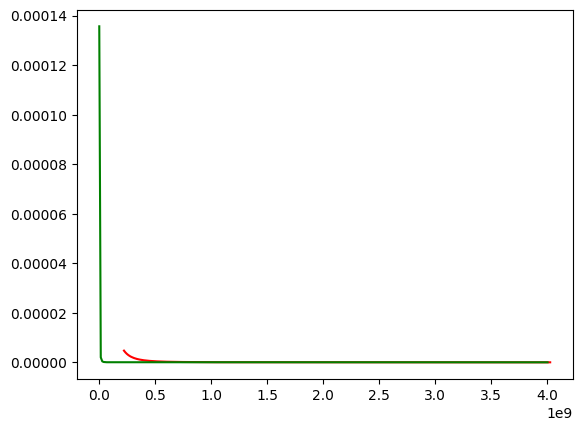

In [48]:
# Function for calculating the gravity gardient disturbance torque
def Tg(R, mu, I):
	Ix, Iy, Iz = I
	coeff = (3 * mu) / (2 * R ** 3)
	Tg = np.abs(Iz - Iy) * coeff
	return Tg

def Tg_neptune(R):
	return Tg(R, mu_neptune, I)

def Tg_triton(R):
	return Tg(R, mu_triton, I)

Tg_neptune = np.vectorize(Tg_neptune)

print(R_neptune)
R1, R2 = R_neptune
Rt1, Rt2 = R_triton
R_range = np.linspace(R1, R2, 300)
Rt_range = np.linspace(Rt1, Rt2, 300)
Tg_range = Tg_neptune(R_range)
Tgt_range = Tg_triton(Rt_range)
plt.plot(R_range, Tg_range, color="red")
plt.plot(Rt_range, Tgt_range, color="green")
plt.show()
